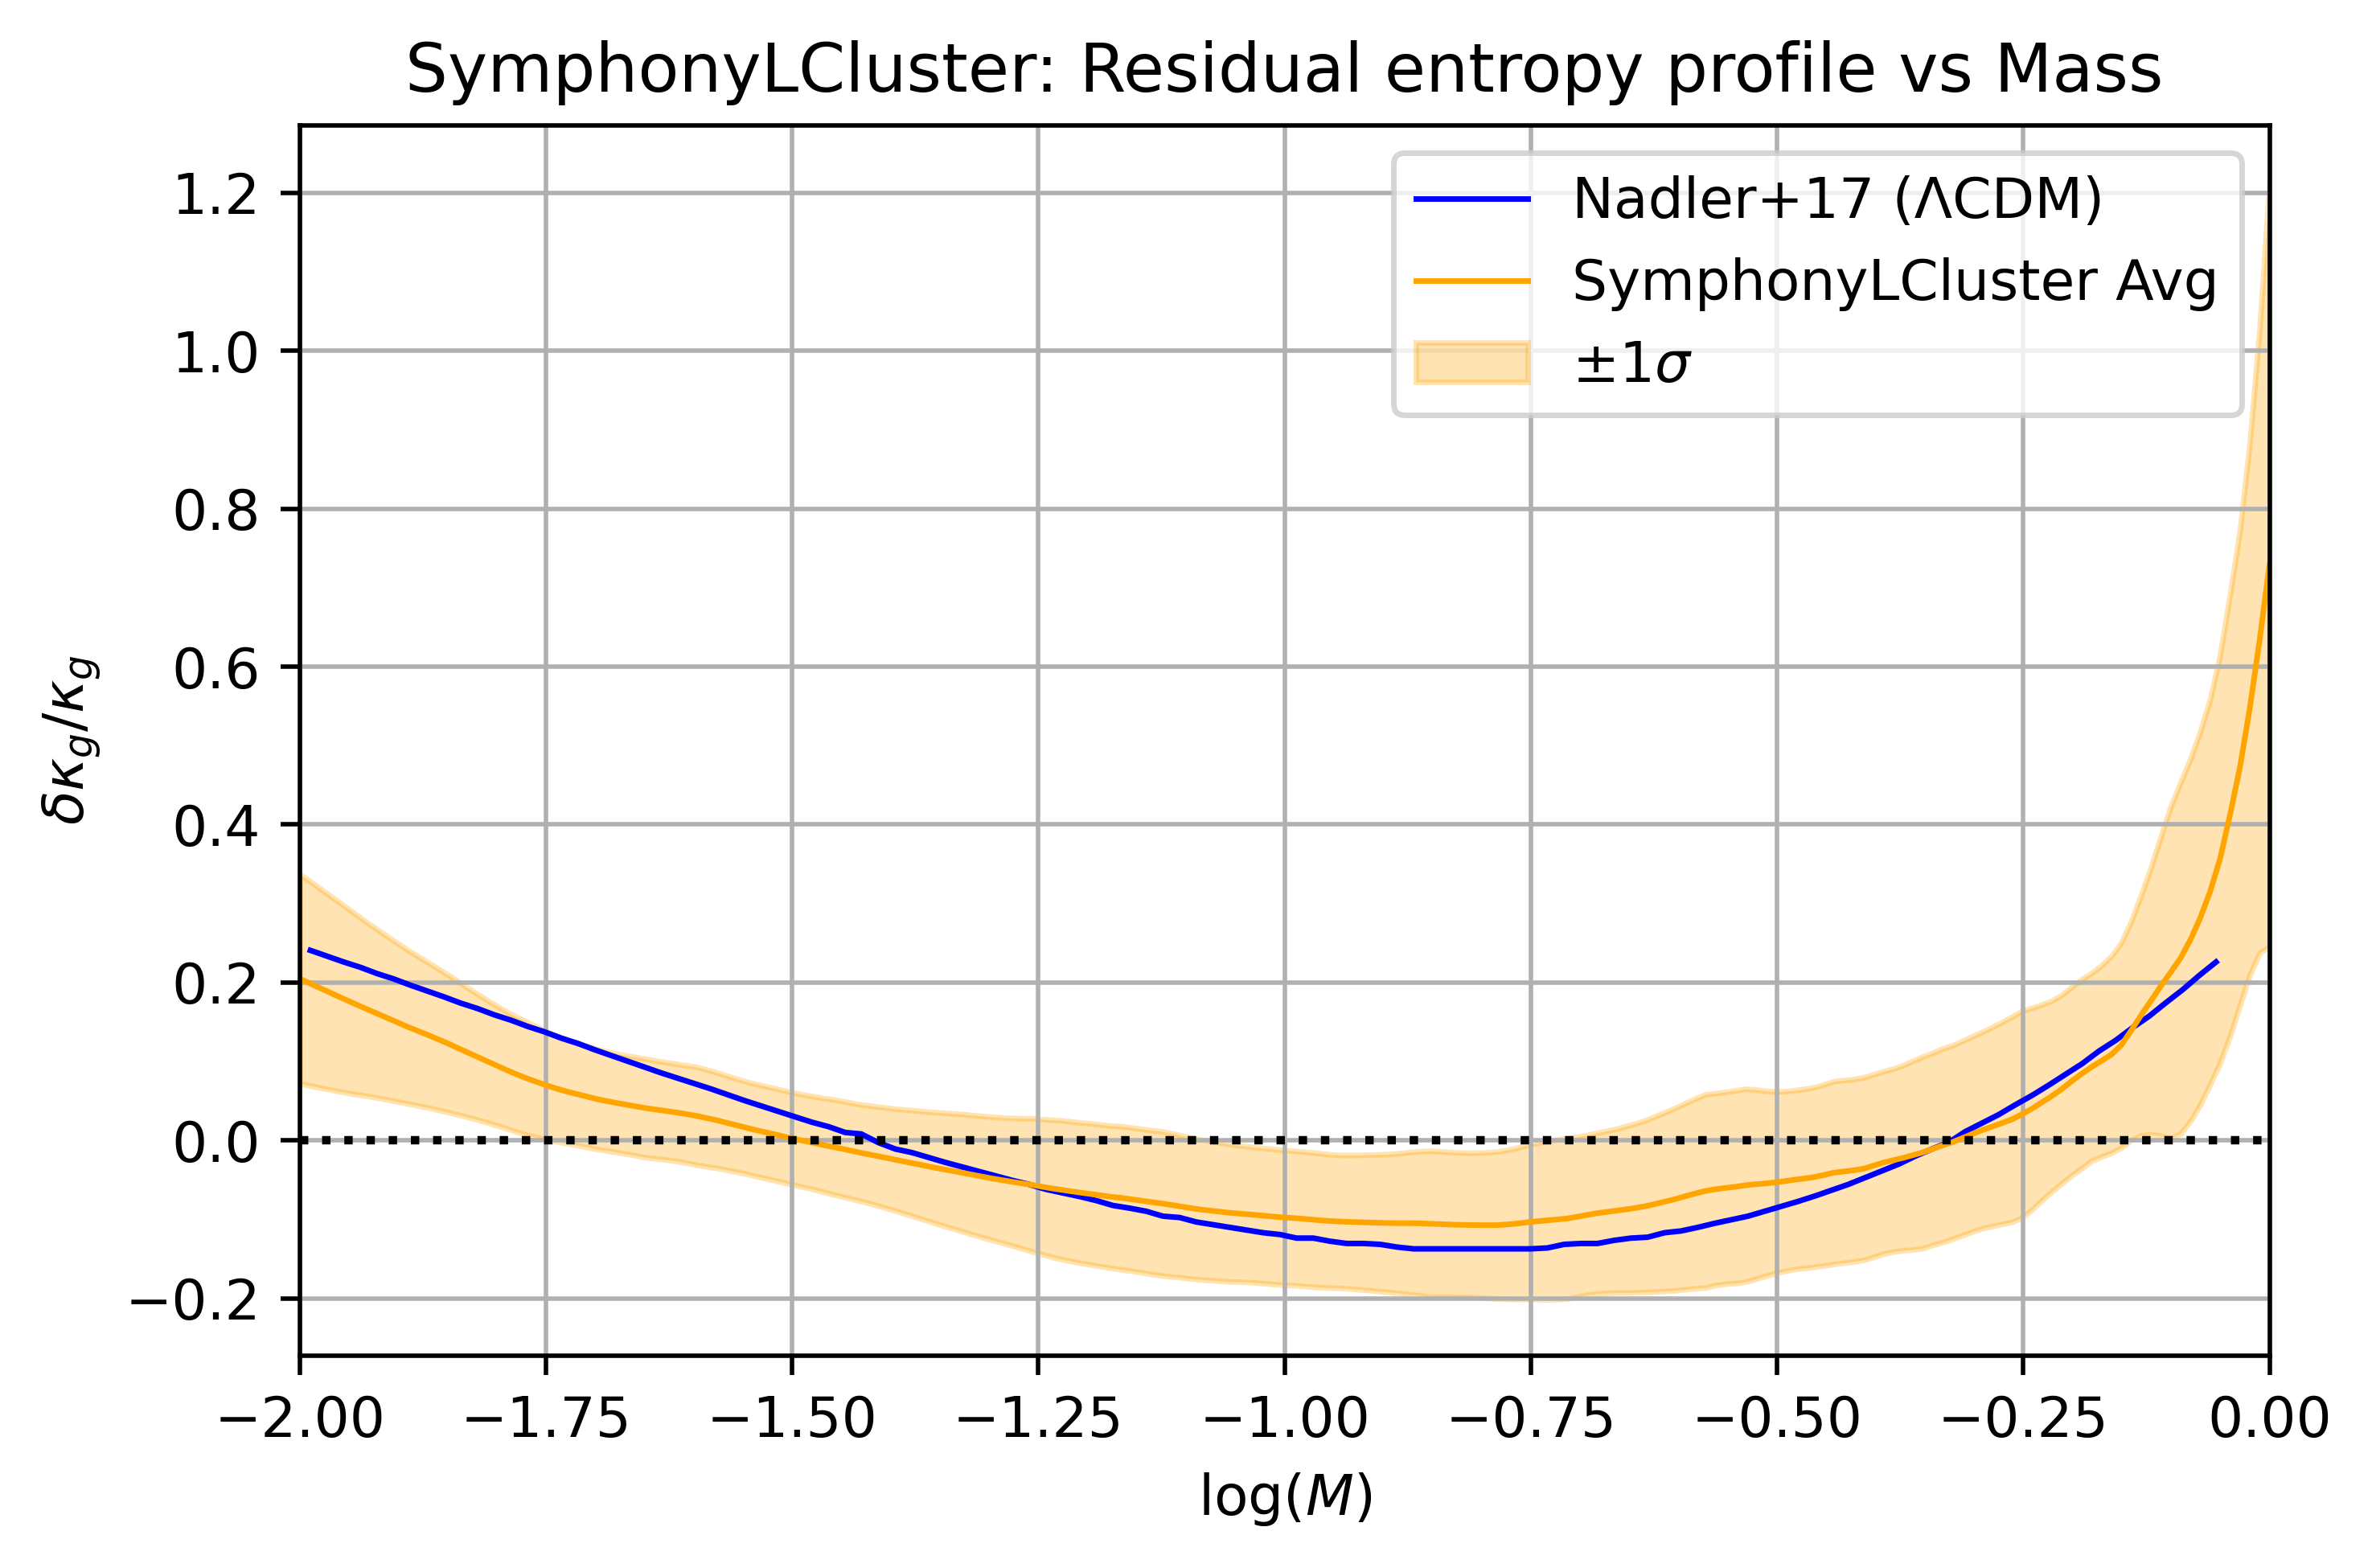

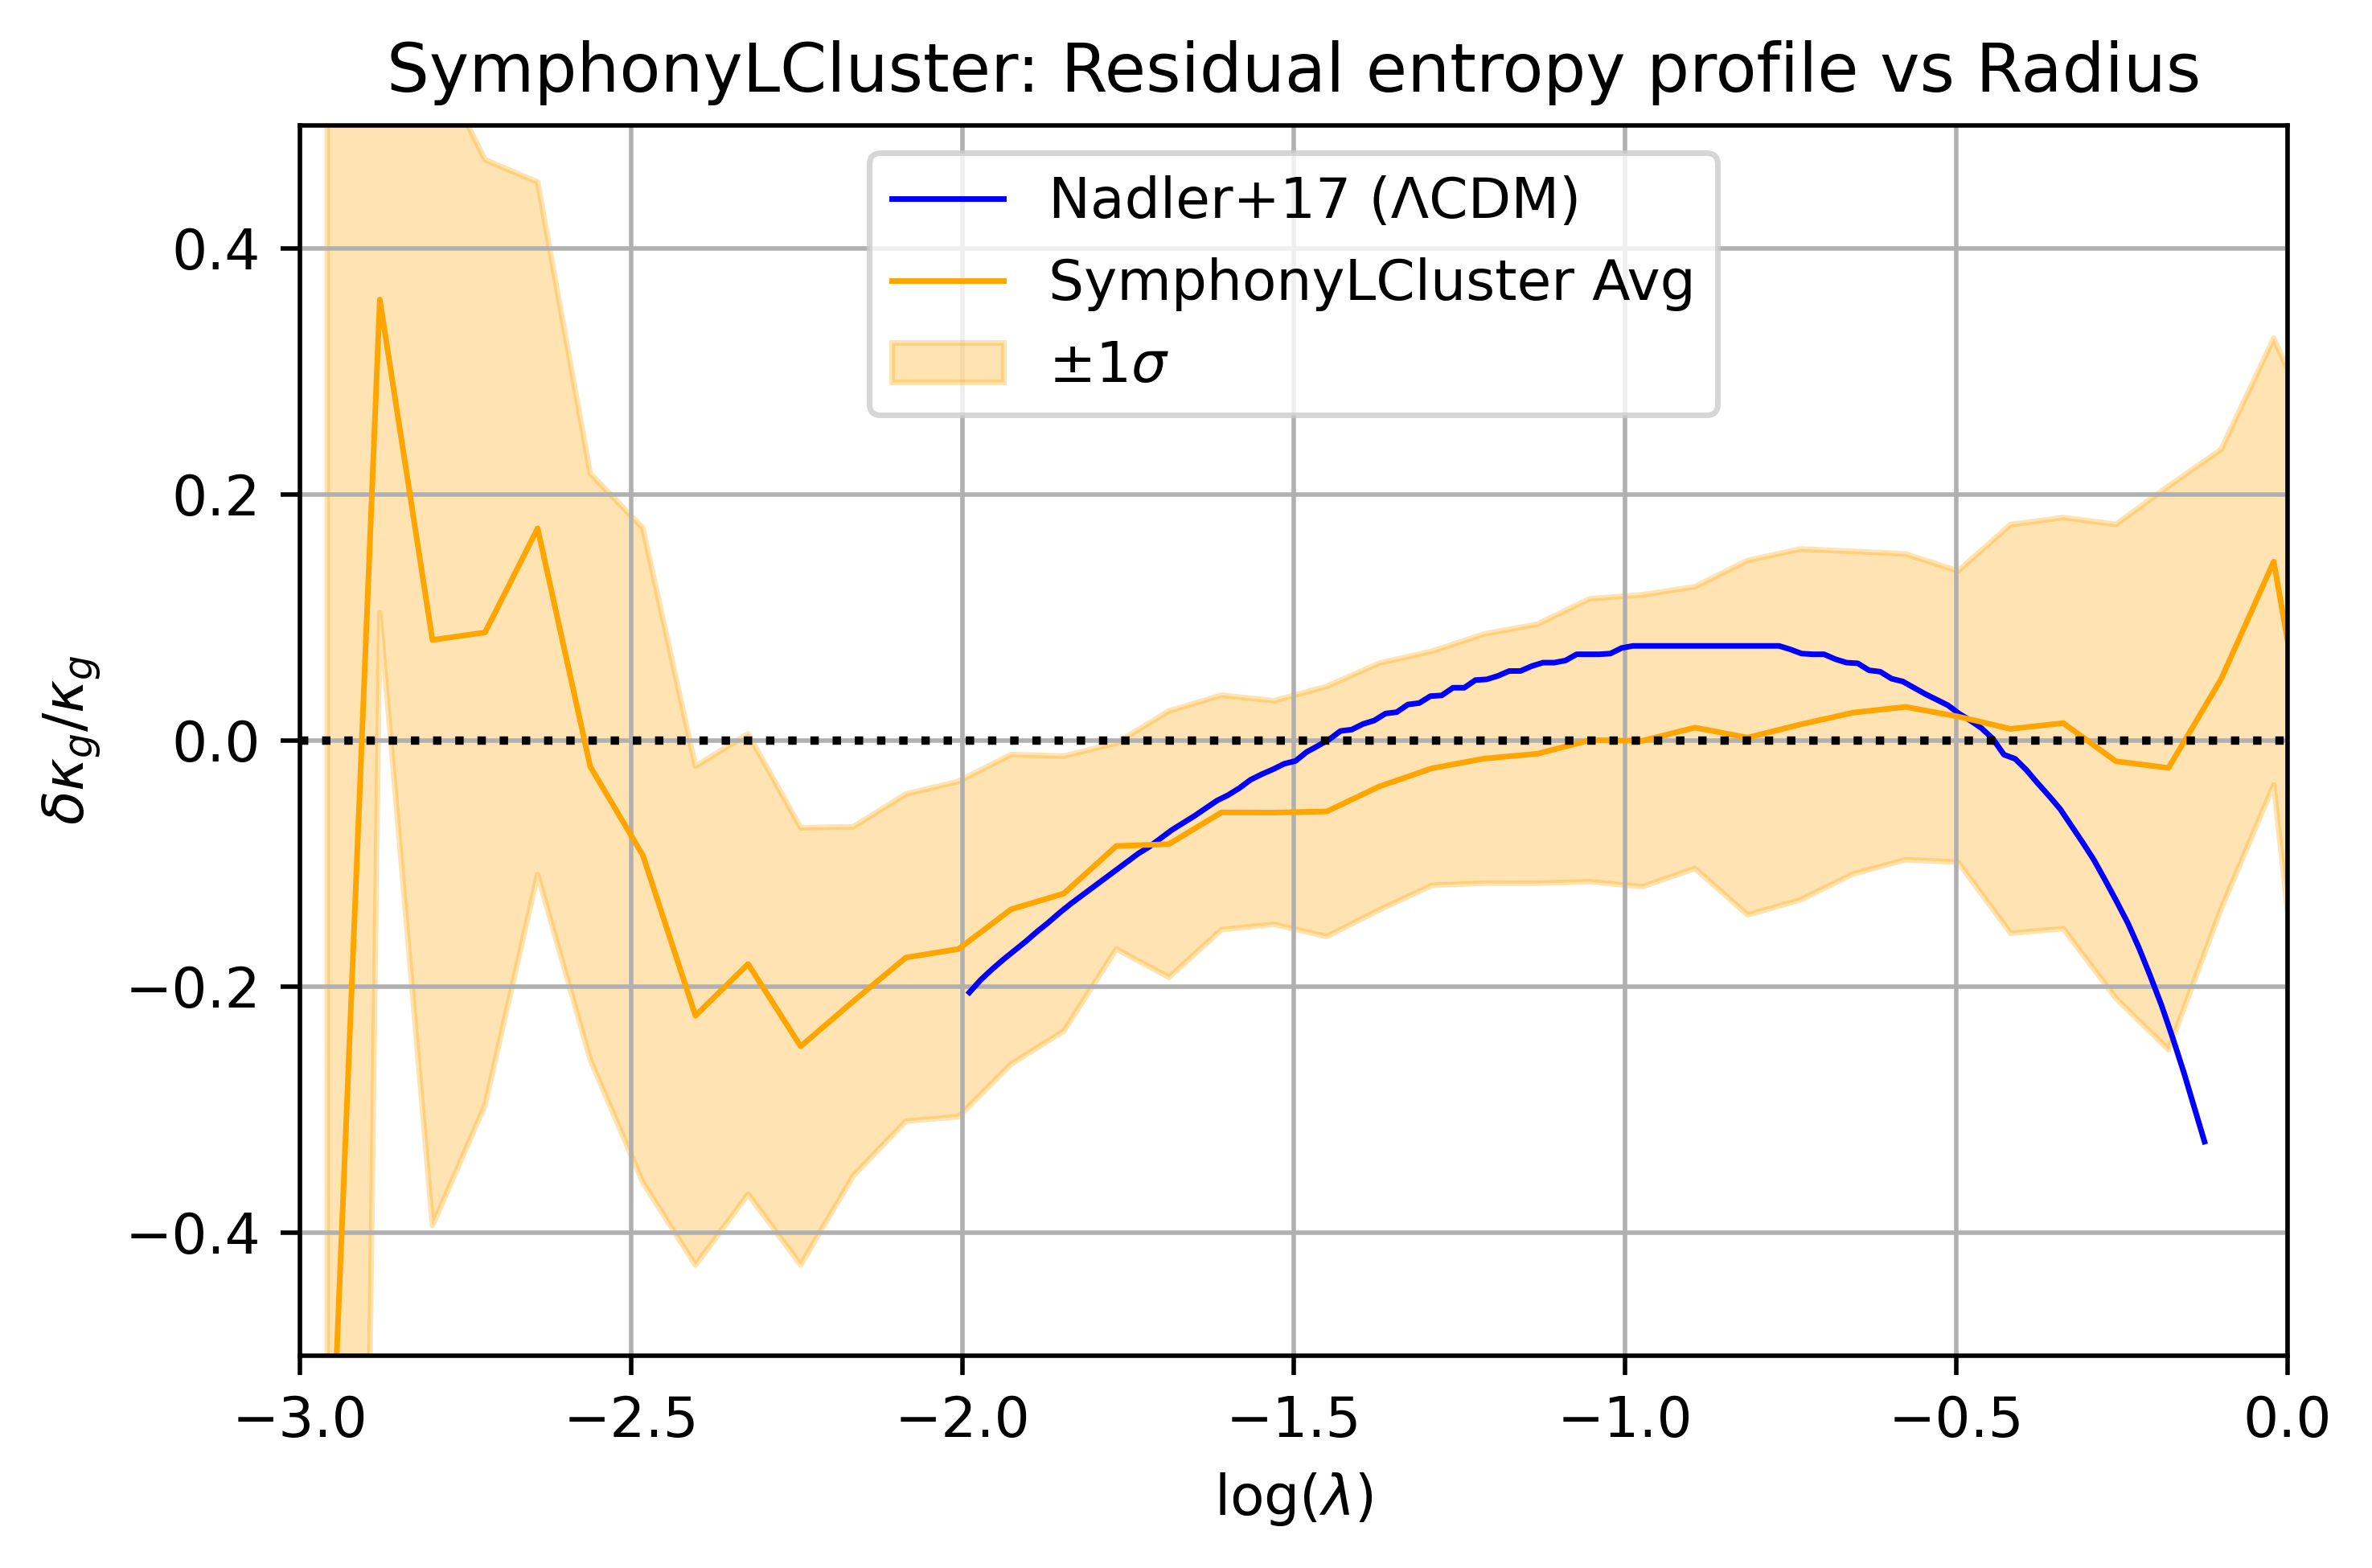

In [53]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import linregress

def plot_ppsd_residual_vs_nadler(base_dir, suite_name,
                                  nadler_mass_path, nadler_radius_path,
                                  logm_range=(-2.0, 0.0), r_xlim=(-3, 0), m_xlim=(-2, 0)):

    profile_dir = os.path.join(base_dir, suite_name, "ppsd_profiles")

    logm_grid = np.linspace(logm_range[0], logm_range[1], 200)
    m_grid = 10**logm_grid
    r_ref = None
    log_r = None

    residual_r_stack = []
    residual_m_stack = []

    for f in sorted([f for f in os.listdir(profile_dir) if f.endswith(".csv")]):
        df = pd.read_csv(os.path.join(profile_dir, f))
        r = df['r_scaled'].values
        m = df['m_scaled'].values
        Q = df['Q_r'].values

        if r_ref is None:
            r_ref = r
            log_r = np.log10(r_ref)

        valid_r = (Q > 0) & (r > 0)
        if np.sum(valid_r) > 5:
            logQr = np.log10(Q[valid_r])
            logR = np.log10(r[valid_r])
            slope, intercept, *_ = linregress(logR, logQr)
            Qfit = 10**intercept * r[valid_r]**slope
            kappa = Q[valid_r]**(2/3)
            kappa_fit = Qfit**(2/3)
            residual = (kappa_fit - kappa) / kappa_fit
            interp_resid = np.interp(log_r, logR, residual, left=np.nan, right=np.nan)
            residual_r_stack.append(interp_resid)

        valid_m = (m > 0) & (Q > 0)
        if np.sum(valid_m) > 5:
            fQm = interp1d(np.log10(m[valid_m]), np.log10(Q[valid_m]), bounds_error=False, fill_value=np.nan)
            logQm = fQm(logm_grid)
            Qm = 10**logQm
            valid_interp = np.isfinite(logQm)
            if np.sum(valid_interp) > 5:
                slope, intercept, *_ = linregress(logm_grid[valid_interp], logQm[valid_interp])
                Qm_fit = 10**intercept * m_grid**slope
                kappa = Qm**(2/3)
                kappa_fit = Qm_fit**(2/3)
                residual = (kappa_fit - kappa) / kappa
                residual_m_stack.append(residual)

    residual_r_stack = np.array(residual_r_stack)
    residual_m_stack = np.array(residual_m_stack)

    residual_r = np.nanmean(residual_r_stack, axis=0)
    residual_r_std = np.nanstd(residual_r_stack, axis=0)
    residual_m = np.nanmean(residual_m_stack, axis=0)
    residual_m_std = np.nanstd(residual_m_stack, axis=0)

    nadler_mass = pd.read_csv(nadler_mass_path)
    nadler_radius = pd.read_csv(nadler_radius_path)
    nadler_mass.columns = [c.strip() for c in nadler_mass.columns]
    nadler_radius.columns = [c.strip() for c in nadler_radius.columns]

    plt.figure(figsize=(6,4), dpi=500)
    plt.plot(nadler_mass['x'], nadler_mass['y'], label='Nadler+17 (ΛCDM)', color='blue', lw=1)
    plt.plot(logm_grid, residual_m, label=f'{suite_name} Avg', color='orange', lw=1)
    plt.fill_between(logm_grid, residual_m - residual_m_std, residual_m + residual_m_std,
                     color='orange', alpha=0.3, label=r'$\pm 1\sigma$')
    plt.axhline(0, color='k', linestyle=':')
    plt.xlim(m_xlim)
    plt.xlabel(r'$\log(M)$')
    plt.ylabel(r'$\delta \kappa_g / \kappa_g$')
    plt.title(f'{suite_name}: Residual entropy profile vs Mass')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,4), dpi=500)
    plt.plot(nadler_radius['x'], nadler_radius['y'], label='Nadler+17 (ΛCDM)', color='blue', lw=1)
    plt.plot(log_r, residual_r, label=f'{suite_name} Avg', color='orange', lw=1)
    plt.fill_between(log_r, residual_r - residual_r_std, residual_r + residual_r_std,
                     color='orange', alpha=0.3, label=r'$\pm 1\sigma$')
    plt.axhline(0, color='k', linestyle=':')
    plt.xlim(r_xlim)
    plt.ylim((-0.5,0.5))
    plt.xlabel(r'$\log(\lambda)$')
    plt.ylabel(r'$\delta \kappa_g / \kappa_g$')
    plt.title(f'{suite_name}: Residual entropy profile vs Radius')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_ppsd_residual_vs_nadler(
    base_dir="/Users/fengbocheng/Projects/Symphony-PPSD/output",
    suite_name="SymphonyLCluster",
    nadler_mass_path="/Users/fengbocheng/Projects/Symphony-PPSD/overplot/Nadler+17_figure10a.csv",
    nadler_radius_path="/Users/fengbocheng/Projects/Symphony-PPSD/overplot/Nadler+17_figure10b_blue.csv"
)